# Imports

In [ ]:
!pip install -q -U transformers datasets segments-ai evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.

In [ ]:
hf_dataset_identifier = "PushkarA07/app2017-A3_Apr26"

In [ ]:
from datasets import load_dataset
ds = load_dataset(hf_dataset_identifier)
test_ds = ds["train"]

README.md:   0%|          | 0.00/333 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/870M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25112 [00:00<?, ? examples/s]

In [ ]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
processor = SegformerImageProcessor.from_pretrained("PushkarA07/segformer-b0-finetuned-net-4Sep")
model = SegformerForSemanticSegmentation.from_pretrained(f"PushkarA07/segformer-b0-finetuned-net-4Sep")

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

# Model Inference

In [ ]:
from PIL import Image as PILImage
from skimage.exposure import match_histograms
import torch
from PIL import Image
import numpy as np
import torch.nn.functional as nnf
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datasets import Dataset, DatasetDict, Image as HFDatasetImage
from concurrent.futures import ThreadPoolExecutor
import cv2
import re

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
if torch.cuda.is_available():
    model.half()

# Directory
output_dir = "plots2"
os.makedirs(output_dir, exist_ok=True)
new_dataset = []
batch_size = 64

# --- Helper: isotropic dilation ---
def isotropic_dilate(mask: np.ndarray, kernel_size=(5, 5), iterations=1):
    mask = mask.astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    return cv2.dilate(mask, kernel, iterations=iterations)

# --- Helper: count clusters ---
def count_clusters(mask: np.ndarray, kernel_size=(5, 5), iterations=1):
    dilated = isotropic_dilate(mask, kernel_size=kernel_size, iterations=iterations)
    num_labels, _ = cv2.connectedComponents(dilated)
    return num_labels - 1  # exclude background

# --- Helper: detect brain tile by dominant color
def is_brain_tile_by_color(image_np, percentage_required=0.7):
    if image_np.dtype != np.uint8:
        image_np = (image_np - image_np.min()) / (np.ptp(image_np) + 1e-8)
        image_np = (image_np * 255).astype(np.uint8)

    h, w, _ = image_np.shape
    pixels = image_np.reshape(-1, 3)
    # cluster ranges found using clustering
    cluster_1 = np.array([177,166,165])
    cluster_3 = np.array([153,143,147])
    white = np.array([254,254,254])
    dark_threshold = 50

    not_dark = np.any(pixels >= dark_threshold, axis=1)
    not_white = np.any(np.abs(pixels - white) > 10, axis=1)
    valid_pixels = pixels[not_dark & not_white]

    if valid_pixels.shape[0] == 0:
        return False

    diff1 = np.abs(valid_pixels - cluster_1).max(axis=1) <= 34
    diff3 = np.abs(valid_pixels - cluster_3).max(axis=1) <= 34

    count_valid = np.sum(diff1 | diff3)
    match_percentage = count_valid / valid_pixels.shape[0]

    return match_percentage >= percentage_required

# --- Helper: extract row and column from filename
def extract_row_col(filename):
    match = re.search(r'r(\d+)_c(\d+)', filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
        return row, col
    else:
        raise ValueError(f"Filename does not match pattern: {filename}")

# --- Main function for processing batch
def process_batch(batch_images, batch_names):
    inputs = processor(images=batch_images, return_tensors="pt").to(device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model(**inputs)

    logits = outputs.logits
    upsampled_logits = nnf.interpolate(
        logits, size=(512, 512), mode="bilinear", align_corners=False
    )

    pred_segs = upsampled_logits.argmax(dim=1).cpu().numpy()

    def save_and_record(args):
        pred_seg, name = args
        row, col = extract_row_col(name)
        save_name = f"tile_r{row:03d}_c{col:03d}.png"
        save_path = os.path.join(output_dir, save_name)
        pred_image = Image.fromarray((pred_seg * 255).astype(np.uint8))
        pred_image.save(save_path)

        cluster_count = count_clusters(pred_seg == 1,iterations=2)

        record = {
            "image_name": save_name,
            "row": row,
            "col": col,
            "cluster_count": cluster_count
        }
        return record

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(save_and_record, zip(pred_segs, batch_names)))
    new_dataset.extend(results)

# --- Handle blank tiles
def process_blank_batch(blank_names):
    blank_pred_seg = np.zeros((512, 512), dtype=np.uint8)

    def save_blank(name):
        row, col = extract_row_col(name)
        save_name = f"tile_r{row:03d}_c{col:03d}.png"
        save_path = os.path.join(output_dir, save_name)
        Image.fromarray(blank_pred_seg).save(save_path)
        record = {
            "image_name": save_name,
            "row": row,
            "col": col,
            "cluster_count": 0
        }
        return record

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(save_blank, blank_names))
    new_dataset.extend(results)

In [ ]:
# --- Process all images in batches ---
for i in tqdm(range(0, len(test_ds), batch_size)):
    if hasattr(test_ds, 'select'):
        batch = test_ds.select(range(i, min(i + batch_size, len(test_ds))))
    else:
        batch = test_ds[i: i + batch_size]

    batch_images_to_predict = []
    batch_names_to_predict = []
    blank_names = []

    for item in batch:
        if isinstance(item, dict):
            image_np = np.array(item['pixel_values'])
            filename = item['image_name']
        else:
            image_np = np.array(item[0])
            filename = item[1]

        row, col = extract_row_col(filename)
        if row is None or col is None or not (40 <= row <= 138) or not (40 <= col <= 150):
            blank_names.append(filename)
            continue

        image_np_norm = (image_np - image_np.min()) / (np.ptp(image_np) + 1e-8)
        image_pil = Image.fromarray((image_np_norm * 255).astype(np.uint8))

        if is_brain_tile_by_color(image_np):
            batch_images_to_predict.append(image_pil)
            batch_names_to_predict.append(filename)
        else:
            blank_names.append(filename)

    if batch_images_to_predict:
        process_batch(batch_images_to_predict, batch_names_to_predict)
    if blank_names:
        process_blank_batch(blank_names)

new_dataset_df = pd.DataFrame(new_dataset)
new_dataset_df['image_name'] = new_dataset_df['image_name'].apply(lambda x: os.path.join(output_dir, x))
new_dataset_df.to_csv(os.path.join(output_dir, "new_dataset.csv"), index=False)

  0%|          | 0/393 [00:00<?, ?it/s]

/tmp/ipython-input-2021580879.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


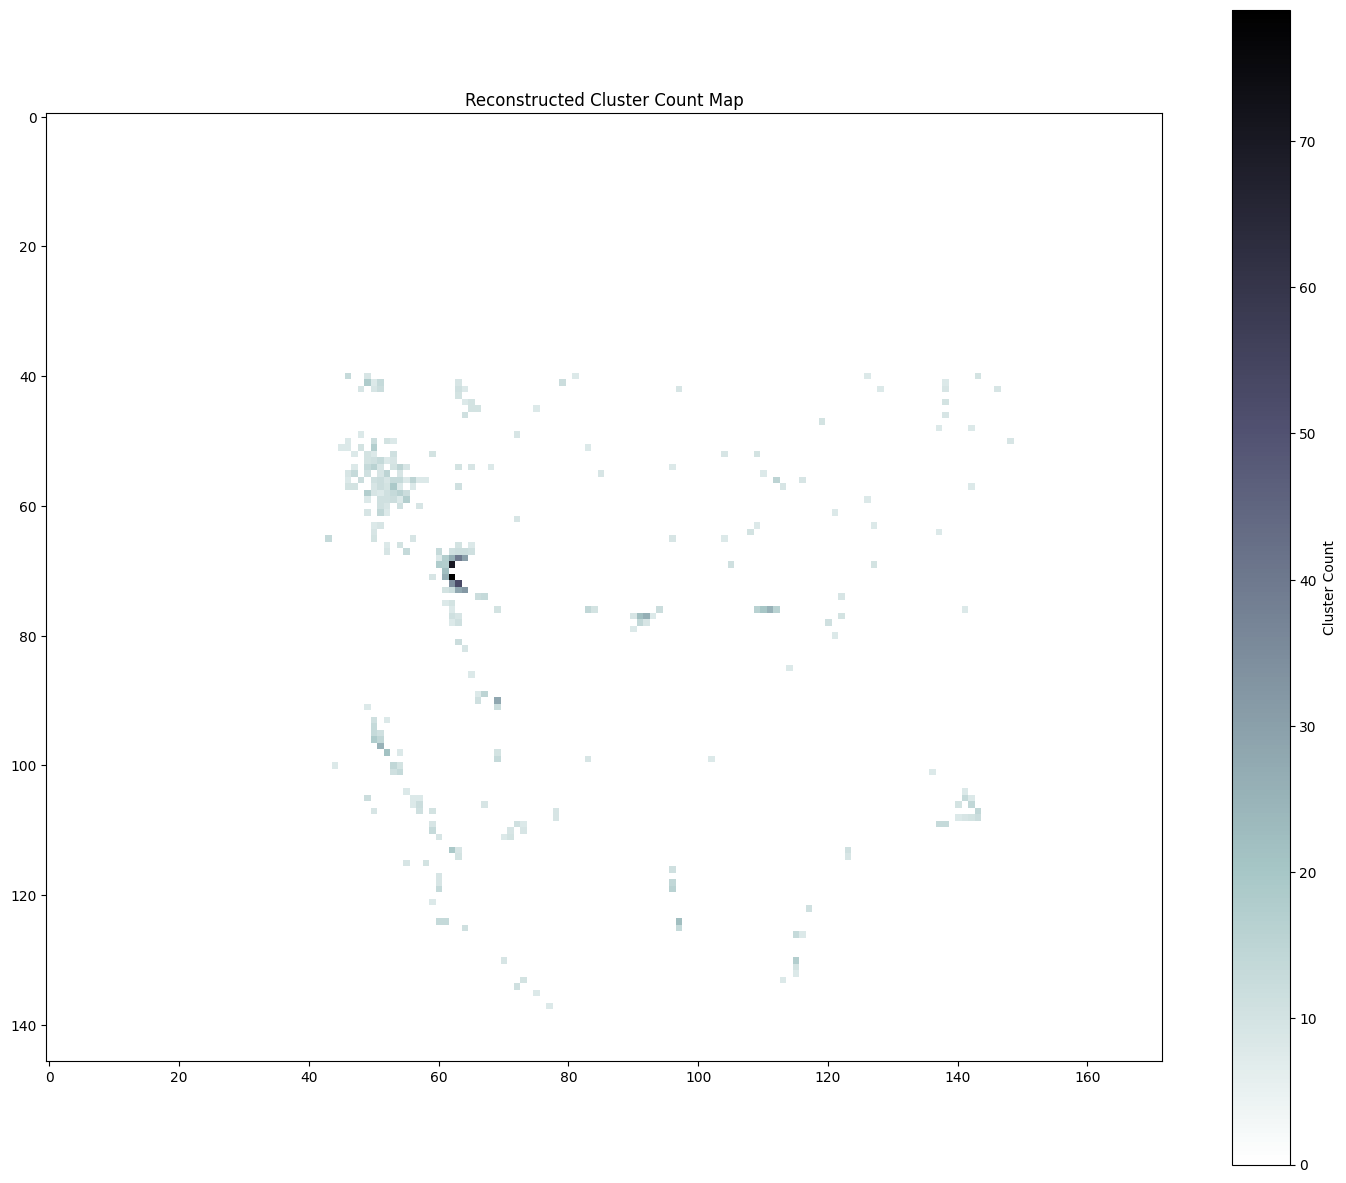

In [ ]:
tile_map = {}
threshold = 7
for _, row in new_dataset_df.iterrows():
    cluster_count = row['cluster_count']
    if cluster_count > threshold:
        tile_map[(row['row'], row['col'])] = cluster_count

max_row = new_dataset_df['row'].max()
max_col = new_dataset_df['col'].max()

full_grid = np.zeros((max_row + 1, max_col + 1), dtype=np.uint32)
for (r, c), cluster_count in tile_map.items():
    full_grid[r, c] = cluster_count

plt.figure(figsize=(18, 15))
plt.imshow(full_grid, cmap="bone_r", interpolation="nearest")
plt.title("Reconstructed Cluster Count Map")
plt.colorbar(label="Cluster Count")
plt.show() # 2017-1-A3

# Extra

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import regionprops, label
from tqdm.notebook import tqdm
import os
import re

output_dir = "plots2"
os.makedirs(output_dir, exist_ok=True)
tile_cluster_info = []

def extract_row_col(filename):
    match = re.search(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

for fname in tqdm(os.listdir(output_dir)):
    if not fname.endswith(".png"):
        continue
    mask = cv2.imread(os.path.join(output_dir, fname), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    binary = (mask > 127).astype(np.uint8)
    labeled = label(binary, connectivity=2)
    props = regionprops(labeled)

    cluster_sizes = []
    cluster_diameters = []
    cluster_aspect_ratios = []

    for region in props:
        if region.area == 0:
            continue

        cluster_sizes.append(region.area)
        cluster_diameters.append(region.equivalent_diameter)

        # Get contour from region
        # Extract the region's mask
        minr, minc, maxr, maxc = region.bbox
        region_mask = binary[minr:maxr, minc:maxc].copy()
        region_mask[region.image == 0] = 0

        # Find contours
        contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Get the largest contour (should be the region itself)
            contour = max(contours, key=cv2.contourArea)

            if len(contour) >= 5:  # minAreaRect needs at least 5 points
                # Find minimum area rotated rectangle
                rect = cv2.minAreaRect(contour)
                # rect is ((center_x, center_y), (width, height), angle)
                width, height = rect[1]

                # Calculate aspect ratio (longer side / shorter side)
                if height > 0:
                    aspect_ratio = max(width, height) / min(width, height)
                else:
                    aspect_ratio = 1.0
            else:
                # Fallback to axis-aligned bbox for very small regions
                h = maxr - minr
                w = maxc - minc
                aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 1.0
        else:
            # Fallback to axis-aligned bbox if no contour found
            h = maxr - minr
            w = maxc - minc
            aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 1.0

        cluster_aspect_ratios.append(aspect_ratio)

    # Get row/col from filename
    row, col = extract_row_col(fname)
    tile_cluster_info.append({
        "image_name": fname,
        "row": row,
        "col": col,
        "cluster_count": len(cluster_sizes),
        "cluster_sizes": cluster_sizes,
        "cluster_diameters": cluster_diameters,
        "cluster_aspect_ratios": cluster_aspect_ratios
    })

# Convert to DataFrame
tile_cluster_info_df = pd.DataFrame(tile_cluster_info)

  0%|          | 0/25114 [00:00<?, ?it/s]

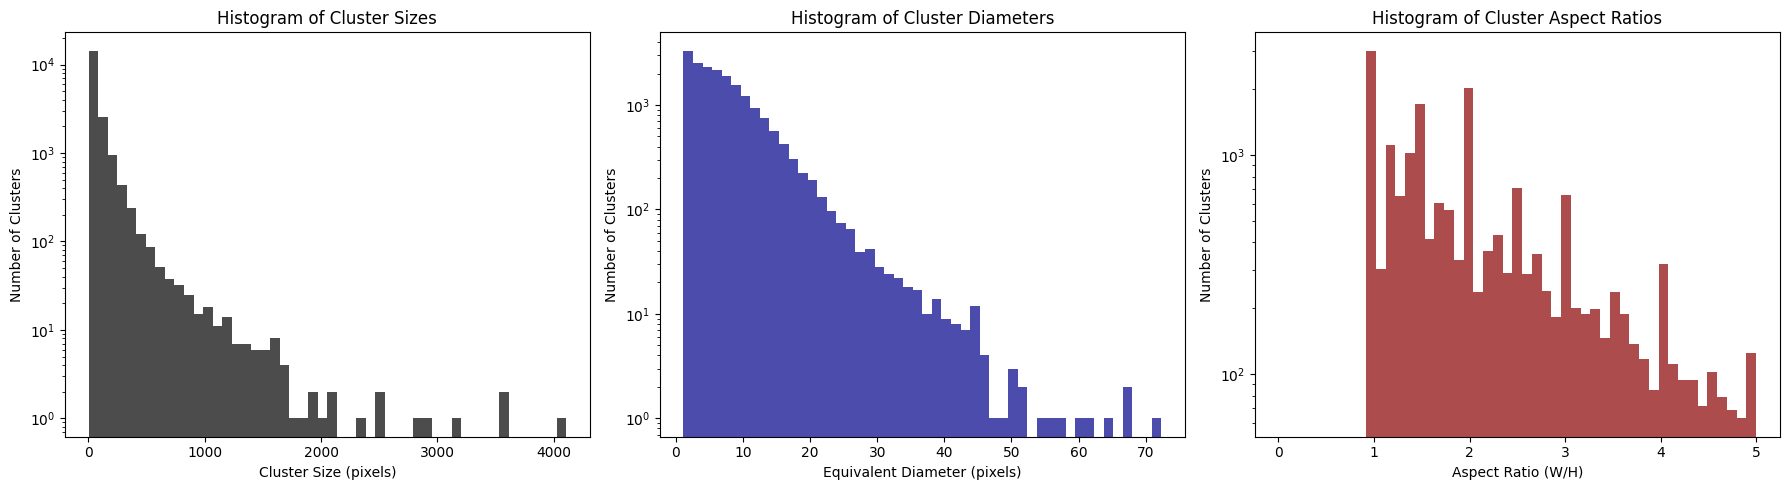

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten lists of sizes/diameters/aspect ratios across all tiles
all_sizes = sum(tile_cluster_info_df["cluster_sizes"].tolist(), [])
all_diameters = sum(tile_cluster_info_df["cluster_diameters"].tolist(), [])
all_aspect_ratios = sum(tile_cluster_info_df["cluster_aspect_ratios"].tolist(), [])

# --- Plot histograms ---
plt.figure(figsize=(18, 5))

# 1. Cluster sizes
plt.subplot(1, 3, 1)
plt.hist(all_sizes, bins=50, color="black", alpha=0.7)
plt.xlabel("Cluster Size (pixels)")
plt.ylabel("Number of Clusters")
plt.title("Histogram of Cluster Sizes")
plt.yscale("log")   # usually very skewed

# 2. Diameters
plt.subplot(1, 3, 2)
plt.hist(all_diameters, bins=50, color="darkblue", alpha=0.7)
plt.xlabel("Equivalent Diameter (pixels)")
plt.ylabel("Number of Clusters")
plt.title("Histogram of Cluster Diameters")
plt.yscale("log")

# 3. Aspect ratios
plt.subplot(1, 3, 3)
plt.hist(all_aspect_ratios, bins=np.linspace(0, 5, 50), color="darkred", alpha=0.7)
plt.xlabel("Aspect Ratio (W/H)")
plt.ylabel("Number of Clusters")
plt.title("Histogram of Cluster Aspect Ratios")
plt.yscale("log")

plt.tight_layout()
plt.show()

/tmp/ipython-input-32364201.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bone_r_cmap = cm.get_cmap('bone_r')


Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

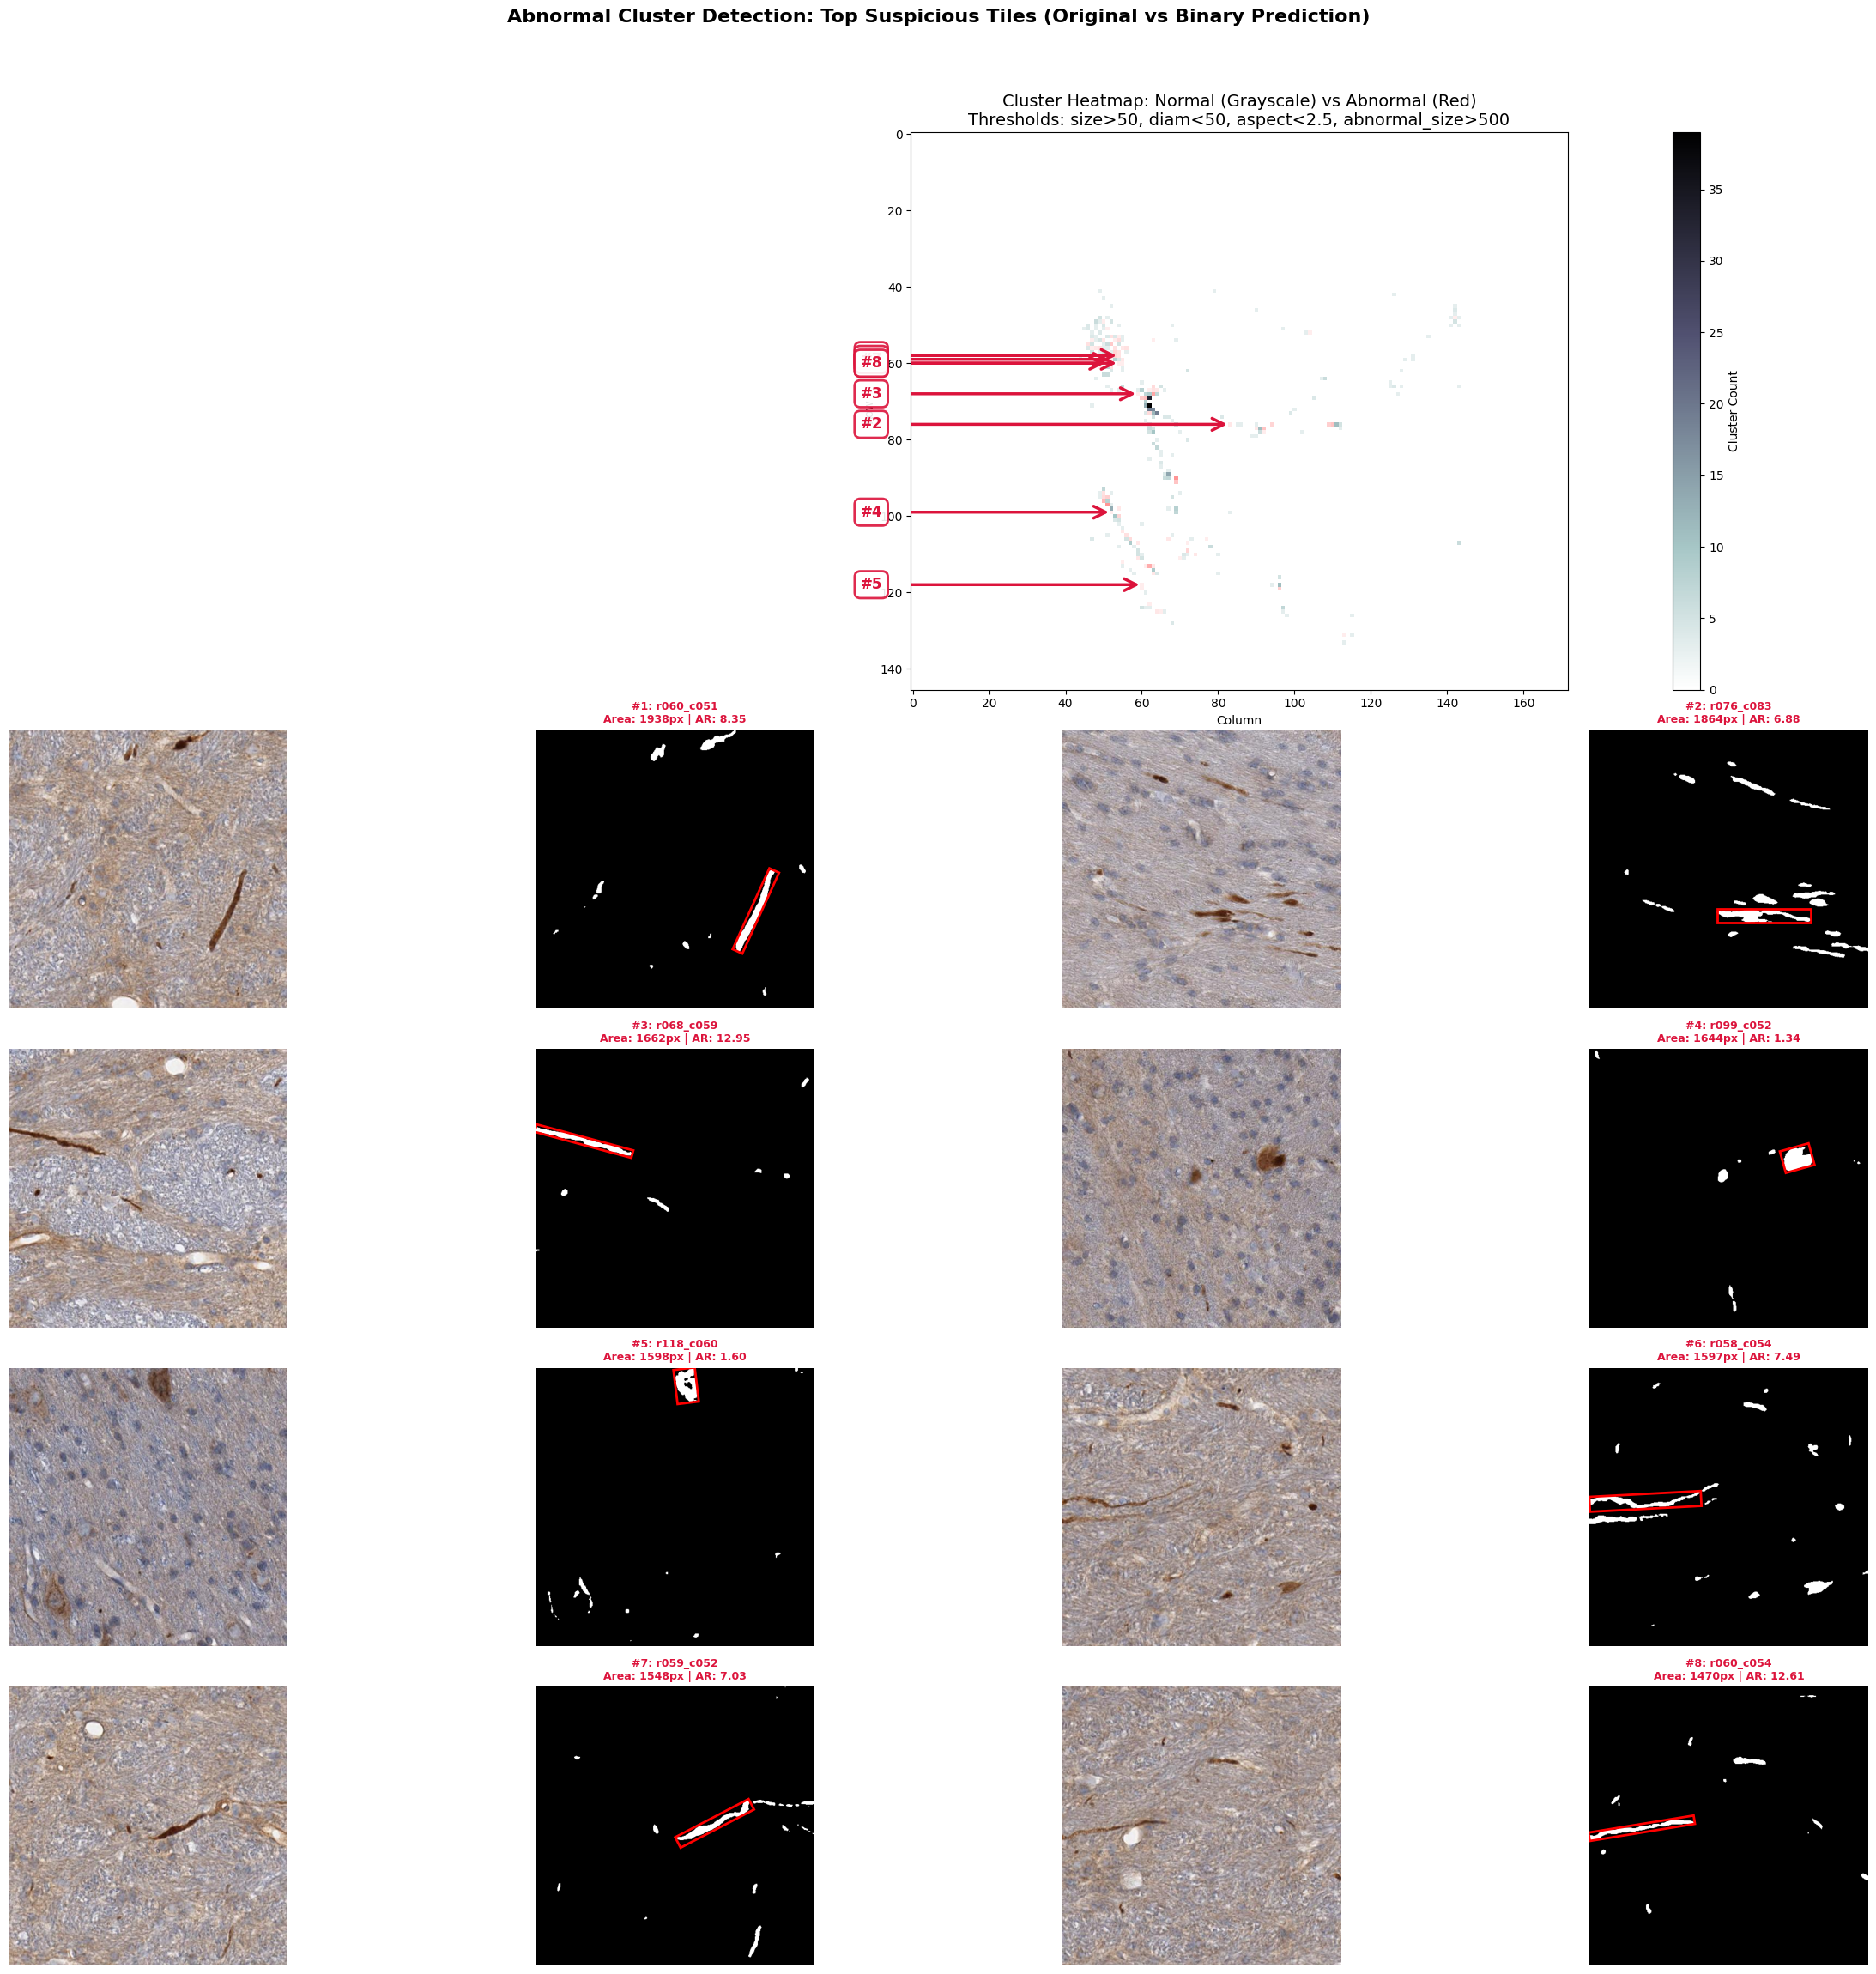


=== SUMMARY ===
Total tiles analyzed: 25112
Tiles with abnormal clusters: 287

Top 8 Most Abnormal Tiles:
  #1: tile_r060_c051.png | Max size: 1938px | Cluster count: 4
  #2: tile_r076_c083.png | Max size: 1864px | Cluster count: 4
  #3: tile_r068_c059.png | Max size: 1662px | Cluster count: 3
  #4: tile_r099_c052.png | Max size: 1644px | Cluster count: 3
  #5: tile_r118_c060.png | Max size: 1598px | Cluster count: 3
  #6: tile_r058_c054.png | Max size: 1597px | Cluster count: 5
  #7: tile_r059_c052.png | Max size: 1548px | Cluster count: 3
  #8: tile_r060_c054.png | Max size: 1470px | Cluster count: 3


In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.gridspec import GridSpec
from skimage.measure import label, regionprops
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# ==============================
# CONFIGURATION
# ==============================
mask_dir = "/content/plots2"  # directory with mask images
hf_ds = test_ds  # HuggingFace dataset containing original images

# Thresholds
size_threshold = 50
diameter_threshold = 50
aspect_threshold = 2.5
count_threshold = 2
ABNORMAL_SIZE = 500
NUM_TOP_TILES = 8

# ==============================
# HELPER FUNCTIONS
# ==============================
def extract_row_col(filename):
    """Extract row/column indices from filenames like 'r001_c002_mask.png'."""
    match = re.search(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None


def compute_cluster_features(mask):
    """Extract sizes, diameters, and aspect ratios of clusters in a mask."""
    binary = (mask > 127).astype(np.uint8)
    labeled = label(binary)
    props = regionprops(labeled)

    sizes, diameters, aspects = [], [], []
    for region in props:
        area = region.area
        minr, minc, maxr, maxc = region.bbox
        height, width = maxr - minr, maxc - minc
        aspect_ratio = max(width, height) / max(1, min(width, height))
        diameter = np.sqrt(4 * area / np.pi)
        sizes.append(area)
        diameters.append(diameter)
        aspects.append(aspect_ratio)
    return sizes, diameters, aspects

def filter_clusters_by_attributes(sizes, diameters, aspects,
                                  size_thr=size_threshold,
                                  diam_thr=diameter_threshold,
                                  aspect_thr=aspect_threshold):
    """Count clusters that pass all thresholds."""
    return sum(
        (s > size_thr) and (d < diam_thr) and (a < aspect_thr)
        for s, d, a in zip(sizes, diameters, aspects)
    )


def has_abnormal_clusters(sizes, abnormal_threshold=ABNORMAL_SIZE):
    """Check if any cluster exceeds abnormal size threshold."""
    return any(s > abnormal_threshold for s in sizes)

# ==============================
# FILTER + LABEL ABNORMAL TILES
# ==============================
tile_cluster_info_df["filtered_cluster_count"] = tile_cluster_info_df.apply(
    lambda row: filter_clusters_by_attributes(
        row["cluster_sizes"], row["cluster_diameters"], row["cluster_aspect_ratios"]
    ),
    axis=1
)

tile_cluster_info_df["has_abnormal"] = tile_cluster_info_df.apply(
    lambda row: has_abnormal_clusters(row["cluster_sizes"]),
    axis=1
)

# Build tile maps
tile_map_normal, tile_map_abnormal = {}, {}

for _, row in tile_cluster_info_df.iterrows():
    if row["filtered_cluster_count"] > count_threshold:
        key = (row["row"], row["col"])
        count = row["filtered_cluster_count"]
        if row["has_abnormal"]:
            tile_map_abnormal[key] = count
        else:
            tile_map_normal[key] = count

max_row = tile_cluster_info_df["row"].max()
max_col = tile_cluster_info_df["col"].max()
grid_normal = np.zeros((max_row + 1, max_col + 1), dtype=np.float32)
grid_abnormal = np.zeros((max_row + 1, max_col + 1), dtype=np.float32)

for (r, c), count in tile_map_normal.items():
    grid_normal[r, c] = count
for (r, c), count in tile_map_abnormal.items():
    grid_abnormal[r, c] = count


# ==============================
# VISUALIZATION
# ==============================
max_val = max(grid_normal.max(), grid_abnormal.max(), 1)
grid_normal_norm = grid_normal / max_val
grid_abnormal_norm = grid_abnormal / max_val

bone_r_cmap = cm.get_cmap('bone_r')
rgb_grid = np.ones((max_row + 1, max_col + 1, 3))

mask_normal = grid_normal > 0
normal_colors = bone_r_cmap(grid_normal_norm[mask_normal])
rgb_grid[mask_normal] = normal_colors[:, :3]

mask_abnormal = grid_abnormal > 0
intensity = grid_abnormal_norm[mask_abnormal]
rgb_grid[mask_abnormal, 0] = 1.0
rgb_grid[mask_abnormal, 1] = 1.0 - intensity * 0.9
rgb_grid[mask_abnormal, 2] = 1.0 - intensity * 0.9

# Identify top abnormal tiles
abnormal_tiles = []
for _, row in tile_cluster_info_df.iterrows():
    if row["has_abnormal"] and row["filtered_cluster_count"] > count_threshold:
        max_size = max(row["cluster_sizes"])
        abnormal_tiles.append({
            "row": row["row"],
            "col": row["col"],
            "image_name": row["image_name"],
            "max_cluster_size": max_size,
            "cluster_count": row["filtered_cluster_count"]
        })
abnormal_tiles_df = pd.DataFrame(abnormal_tiles)
top_abnormal = abnormal_tiles_df.nlargest(NUM_TOP_TILES, "max_cluster_size") if len(abnormal_tiles_df) > 0 else pd.DataFrame()

# ==============================
# VISUALIZATION (UPDATED)
# ==============================
fig = plt.figure(figsize=(26, 24))
# Much tighter layout
gs = GridSpec(5, 4, figure=fig, height_ratios=[2, 1, 1, 1, 1], hspace=0.12, wspace=0.02)

# --- Main heatmap ---
ax_main = fig.add_subplot(gs[0, :])
ax_main.imshow(rgb_grid, interpolation="nearest")
ax_main.set_title(
    f"Cluster Heatmap: Normal (Grayscale) vs Abnormal (Red)\n"
    f"Thresholds: size>{size_threshold}, diam<{diameter_threshold}, aspect<{aspect_threshold}, abnormal_size>{ABNORMAL_SIZE}",
    fontsize=14
)
ax_main.set_xlabel("Column")
ax_main.set_ylabel("Row")

# --- Improved: labels stay attached to arrows (inside/outside with offset) ---
# --- Draw straight arrows + clear labels --- if len(top_abnormal) > 0:
for plot_idx, (df_idx, row_data) in enumerate(top_abnormal.iterrows(), start=1):
  r, c = row_data["row"], row_data["col"] # choose direction to nearest boundary
  if c < max_col / 2:
      x_start, x_end = -5, c
      label_x, ha = -8, 'right'
  else:
      x_start, x_end = max_col + 5, c
      label_x, ha = max_col + 8, 'left'
  if r < max_row / 2:
      y_start, y_end = -5, r
      label_y, va = -8, 'bottom'
  else:
      y_start, y_end = max_row + 5, r
      label_y, va = max_row + 8, 'top' # straight line to the tile
  arrow = FancyArrowPatch( (x_start, r), (c, r), arrowstyle='->', mutation_scale=25, linewidth=2.5, color='#DC143C', zorder=10 )
  ax_main.add_patch(arrow)
  ax_main.text(label_x, r, f"#{plot_idx}", color='#DC143C', fontsize=12, fontweight='bold', ha=ha, va='center', bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='#DC143C', linewidth=2, alpha=0.9))
plt.colorbar(
    plt.cm.ScalarMappable(cmap='bone_r', norm=plt.Normalize(vmin=0, vmax=max_val)),
    ax=ax_main,
    label="Cluster Count"
)

# --- Function to show tile pair (Original + Binary Mask + Rotated Box) ---
def show_tile_pair(ax_orig, ax_mask, fname, mask_dir, hf_ds, plot_number):
    mask_path = os.path.join(mask_dir, fname)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        for ax in [ax_orig, ax_mask]:
            ax.text(0.5, 0.5, f"Mask not found:\n{fname}",
                    ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
        return

    row, col = extract_row_col(fname)
    match = hf_ds.filter(lambda x: extract_row_col(x["image_name"]) == (row, col))
    if len(match) == 0:
        for ax in [ax_orig, ax_mask]:
            ax.text(0.5, 0.5, f"Original not found:\n{fname}",
                    ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
        return

    orig = np.array(match[0]["pixel_values"])
    ax_orig.imshow(orig)
    ax_orig.axis('off')

    binary = (mask > 127).astype(np.uint8)
    labeled = label(binary)
    props = regionprops(labeled)

    ax_mask.imshow(binary, cmap='gray')
    if props:
        best_region = max(props, key=lambda r: r.area)
        minr, minc, maxr, maxc = best_region.bbox
        region_mask = binary[minr:maxr, minc:maxc].copy()
        region_mask[best_region.image == 0] = 0
        contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            if len(contour) >= 5:
                rect = cv2.minAreaRect(contour)
                box = cv2.boxPoints(rect)
                box[:, 0] += minc
                box[:, 1] += minr
                poly = Polygon(box, edgecolor="red", facecolor="none", lw=2)
                ax_mask.add_patch(poly)

                width, height = rect[1]
                ar = max(width, height) / max(1, min(width, height))
                ax_mask.set_title(
                    f"#{plot_number}: r{row:03d}_c{col:03d}\n"
                    f"Area: {best_region.area:.0f}px | AR: {ar:.2f}",
                    fontsize=9, color='#DC143C', fontweight='bold'
                )
    ax_mask.axis('off')


# --- Create pairs with minimal gap ---
for idx in range(len(top_abnormal)):
    fname = top_abnormal.iloc[idx]["image_name"]
    row_idx = (idx // 2) + 1
    pair_pos = idx % 2
    col_start = pair_pos * 2
    ax_orig = fig.add_subplot(gs[row_idx, col_start])
    ax_mask = fig.add_subplot(gs[row_idx, col_start + 1])
    show_tile_pair(ax_orig, ax_mask, fname, mask_dir, hf_ds, idx + 1)

plt.subplots_adjust(top=0.92, bottom=0.03, left=0.03, right=0.97, hspace=0.10, wspace=0.02)
plt.suptitle("Abnormal Cluster Detection: Top Suspicious Tiles (Original vs Binary Prediction)", fontsize=16, fontweight='bold')
plt.show()

# ==============================
# SUMMARY
# ==============================
print("\n=== SUMMARY ===")
print(f"Total tiles analyzed: {len(tile_cluster_info_df)}")
print(f"Tiles with abnormal clusters: {tile_cluster_info_df['has_abnormal'].sum()}")
print(f"\nTop {NUM_TOP_TILES} Most Abnormal Tiles:")
if len(top_abnormal) > 0:
    for i, row in enumerate(top_abnormal.itertuples(), 1):
        print(f"  #{i}: {row.image_name} | Max size: {row.max_cluster_size:.0f}px | Cluster count: {row.cluster_count}")
else:
    print("  No abnormal tiles found.")

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

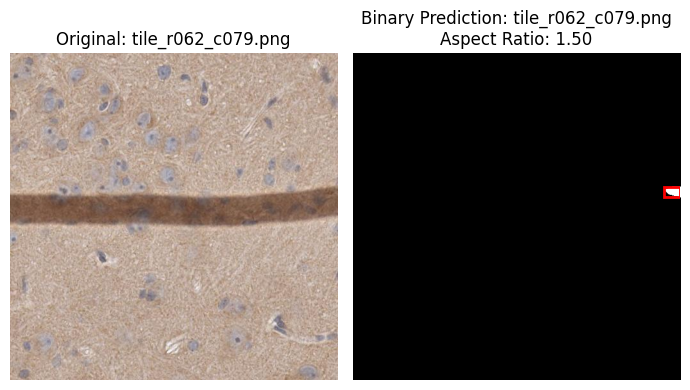

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

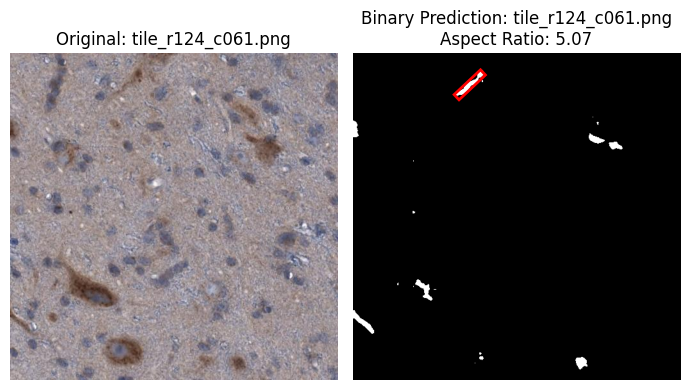

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

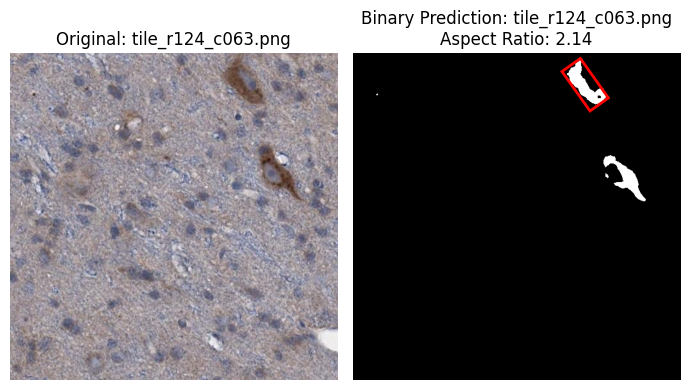

In [ ]:
suspicious = [
    "tile_r062_c079.png",
    "tile_r124_c061.png",
    "tile_r124_c063.png"]
review_suspicious_tiles(suspicious, mask_dir='/content/plots2', hf_ds=test_ds)

In [ ]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from skimage.measure import label, regionprops
import pandas as pd

def extract_row_col(filename):
    match = re.search(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def review_suspicious_tiles(suspicious, mask_dir, hf_ds):
    """
    Show suspicious images: original tile + binary mask side by side.
    Now visualizes the minimum area rotated bounding box.

    suspicious : list of filenames like ["tile_r040_c065.png", ...]
    mask_dir   : directory where mask predictions are saved
    hf_ds      : HuggingFace dataset containing original images
    """
    for fname in suspicious:
        # --- Load mask ---
        mask_path = os.path.join(mask_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[WARN] Mask not found: {mask_path}")
            continue

        # --- Load original image from HF dataset ---
        row, col = extract_row_col(fname)
        match = hf_ds.filter(
            lambda x: extract_row_col(x["image_name"]) == (row, col)
        )
        if len(match) == 0:
            print(f"[WARN] Original not found in HF dataset for {fname}")
            continue
        orig = np.array(match[0]["pixel_values"])  # PIL → numpy

        # --- Label mask regions ---
        binary = (mask > 127).astype(np.uint8)
        labeled = label(binary)
        props = regionprops(labeled)

        # Pick largest region if exists
        rotated_box = None
        if props:
            best_region = max(props, key=lambda r: r.area)
            minr, minc, maxr, maxc = best_region.bbox

            # Extract region mask and find contour
            region_mask = binary[minr:maxr, minc:maxc].copy()
            region_mask[best_region.image == 0] = 0

            # Find contours
            contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                contour = max(contours, key=cv2.contourArea)

                if len(contour) >= 5:
                    # Get minimum area rotated rectangle
                    rect = cv2.minAreaRect(contour)
                    # Get box points (4 corners of rotated rectangle)
                    box = cv2.boxPoints(rect)
                    # Offset by region position in original image
                    box[:, 0] += minc
                    box[:, 1] += minr
                    rotated_box = box

        # --- Plot ---
        plt.figure(figsize=(7, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title(f"Original: {fname}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        if rotated_box is not None:
            # Draw rotated bounding box
            poly = Polygon(rotated_box, edgecolor="red", facecolor="none", lw=2)
            plt.gca().add_patch(poly)

            # Optionally, also show the aspect ratio
            rect = cv2.minAreaRect(contour)
            width, height = rect[1]
            aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 1.0
            plt.title(f"Binary Prediction: {fname}\nAspect Ratio: {aspect_ratio:.2f}")
        else:
            plt.title(f"Binary Prediction: {fname}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

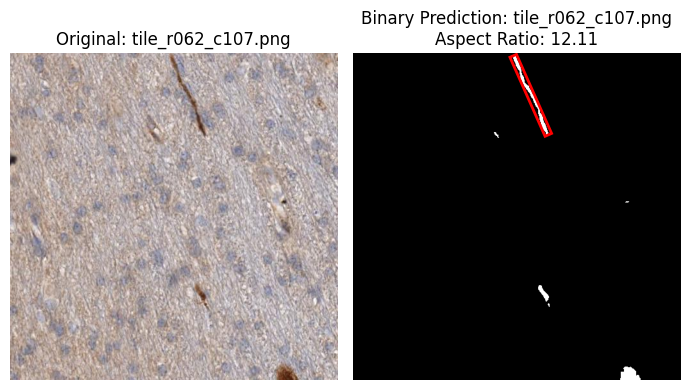

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

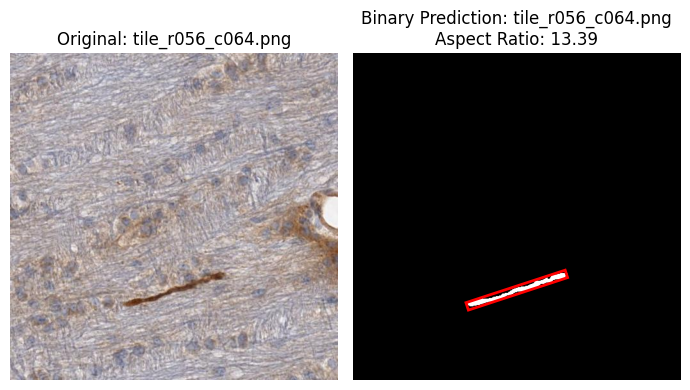

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

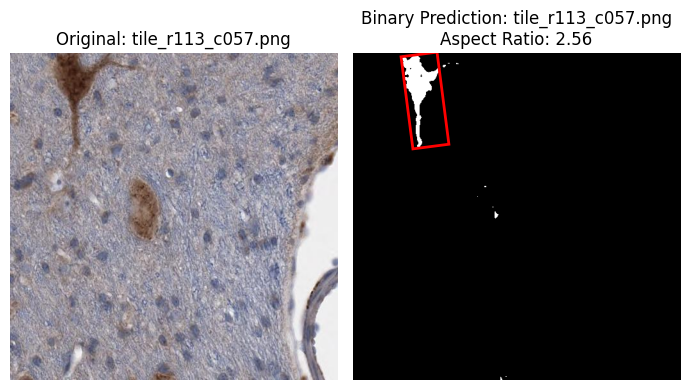

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

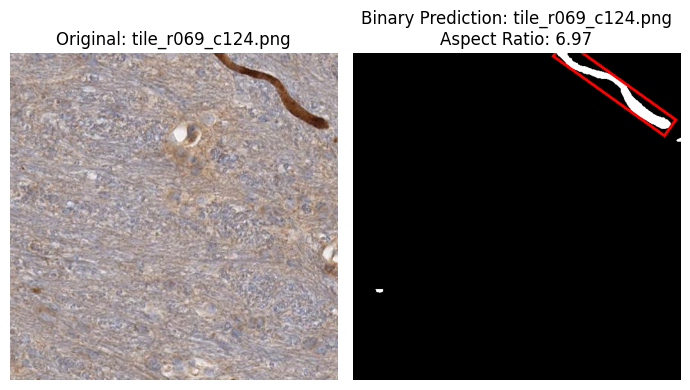

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

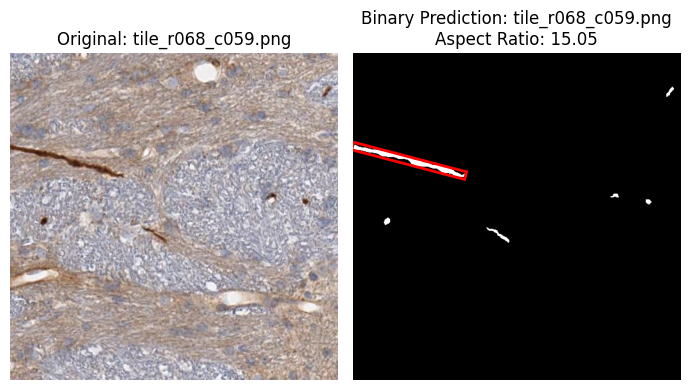

Filter:   0%|          | 0/25112 [00:00<?, ? examples/s]

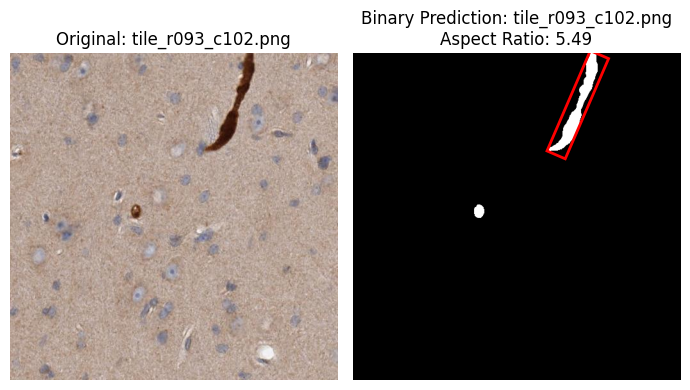

In [ ]:
review_suspicious_tiles(suspicious, mask_dir='/content/plots2', hf_ds=test_ds)

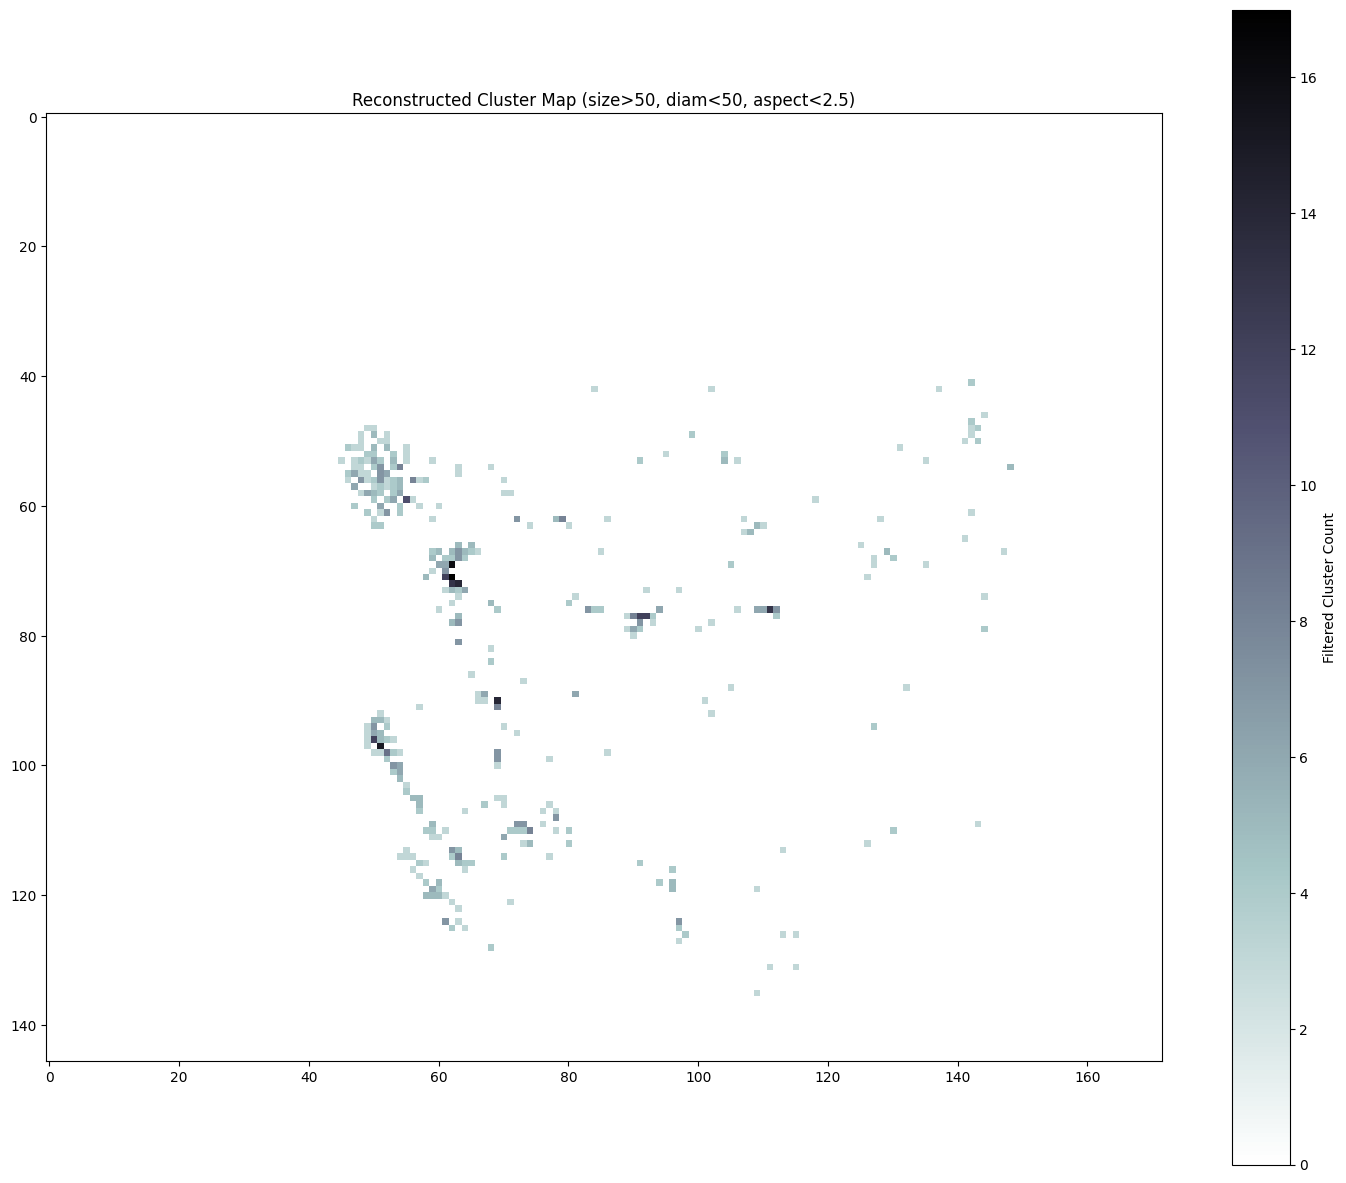

In [ ]:
# --- thresholds ---
size_threshold = 50
diameter_threshold = 50
aspect_threshold = 2.5
count_threshold = 2

def filter_clusters_by_attributes(sizes, diameters, aspects,
                                  size_thr=size_threshold,
                                  diam_thr=diameter_threshold,
                                  aspect_thr=aspect_threshold):
    """Count clusters that pass all thresholds."""
    return sum(
        (s > size_thr) and (d < diam_thr) and (a < aspect_thr)
        for s, d, a in zip(sizes, diameters, aspects)
    )

# --- compute filtered counts ---
tile_cluster_info_df["filtered_cluster_count"] = tile_cluster_info_df.apply(
    lambda row: filter_clusters_by_attributes(
        row["cluster_sizes"], row["cluster_diameters"], row["cluster_aspect_ratios"]
    ),
    axis=1
)

# --- build tile_map with filtered counts ---
tile_map = {}
for _, row in tile_cluster_info_df.iterrows():
    if row["filtered_cluster_count"] > count_threshold:
        tile_map[(row["row"], row["col"])] = row["filtered_cluster_count"]

# --- reconstruct grid ---
max_row = tile_cluster_info_df["row"].max()
max_col = tile_cluster_info_df["col"].max()
full_grid = np.zeros((max_row + 1, max_col + 1), dtype=np.uint32)

for (r, c), count in tile_map.items():
    full_grid[r, c] = count

# --- plot ---
plt.figure(figsize=(18, 15))
plt.imshow(full_grid, cmap="bone_r", interpolation="nearest")
plt.title(
    f"Reconstructed Cluster Map (size>{size_threshold}, diam<{diameter_threshold}, aspect<{aspect_threshold})"
)
plt.colorbar(label="Filtered Cluster Count")
plt.show()

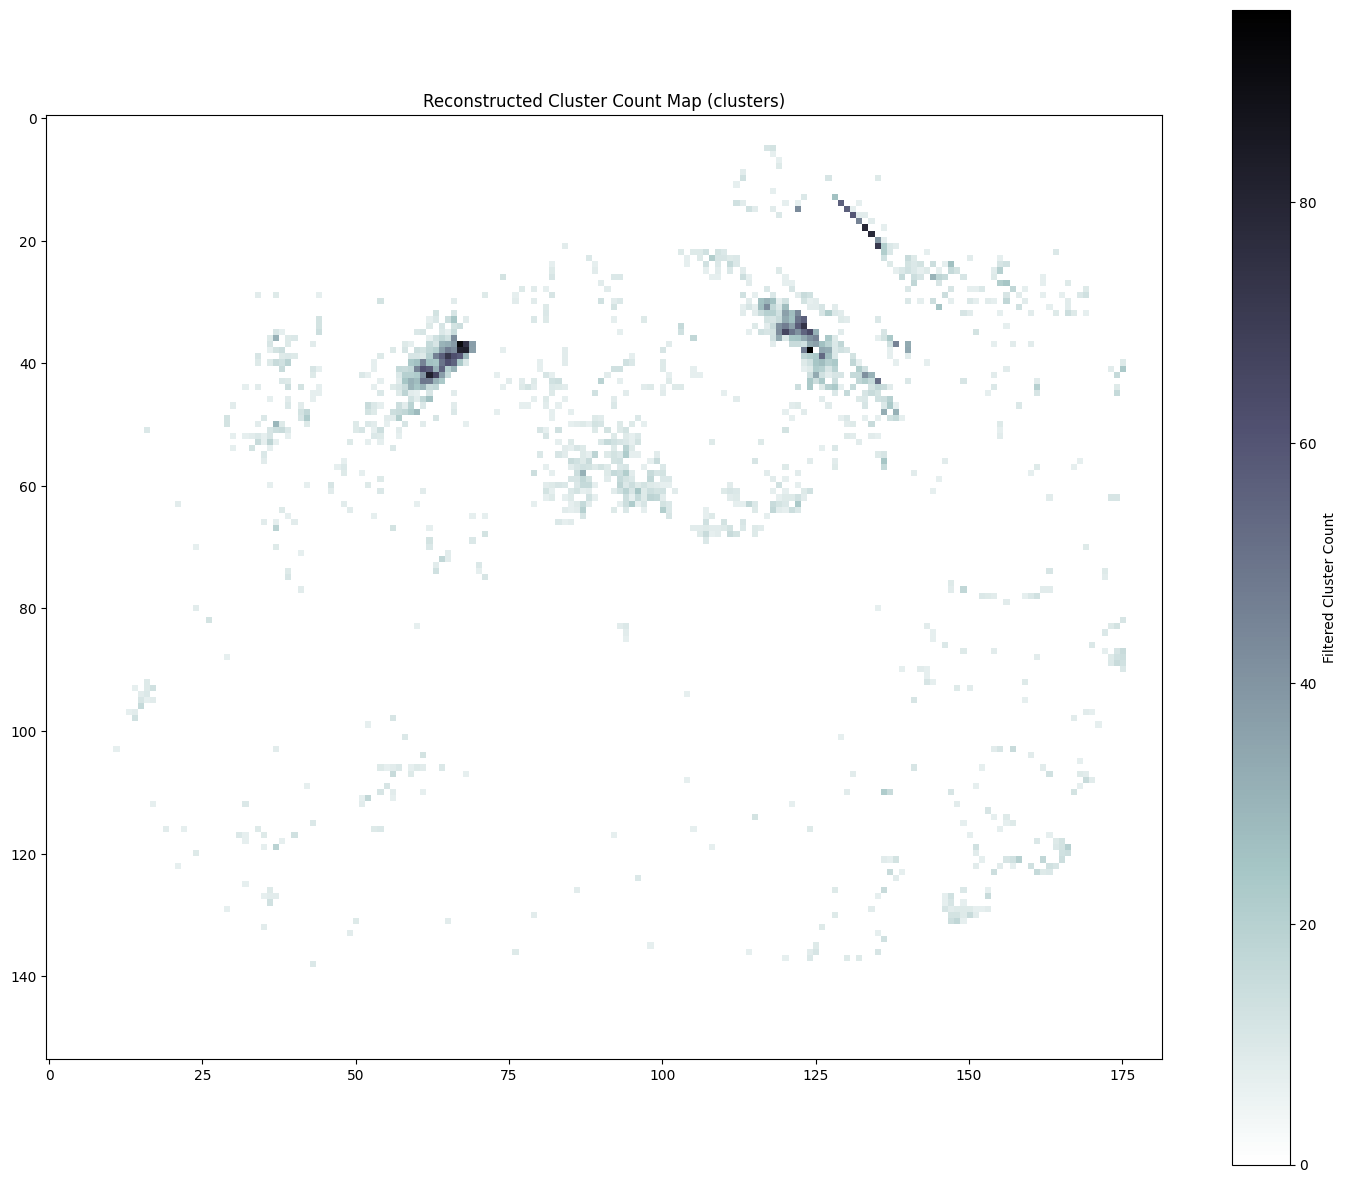

In [ ]:
# Convert list of dicts → DataFrame
tile_cluster_info_df = pd.DataFrame(tile_cluster_info)

def filter_clusters(cluster_sizes, UT=2000):
    """Keep only clusters larger than threshold (in pixels)."""
    return [size for size in cluster_sizes if size < UT]

# Add filtered cluster counts
tile_cluster_info_df["filtered_cluster_count"] = tile_cluster_info_df["cluster_sizes"].apply(
    lambda sizes: len(filter_clusters(sizes, UT=2000))
)

# Extract row, col from filenames
tile_cluster_info_df["row"] = tile_cluster_info_df["image_name"].str.extract(r"r(\d+)_c(\d+)")[0].astype(int)
tile_cluster_info_df["col"] = tile_cluster_info_df["image_name"].str.extract(r"r(\d+)_c(\d+)")[1].astype(int)

# Build tile_map
tile_map = {}
for _, row in tile_cluster_info_df.iterrows():
    if row["filtered_cluster_count"] > 6:
        tile_map[(row["row"], row["col"])] = row["filtered_cluster_count"]

max_row = tile_cluster_info_df["row"].max()
max_col = tile_cluster_info_df["col"].max()

# Reconstruct the grid
full_grid = np.zeros((max_row + 1, max_col + 1), dtype=np.uint32)
for (r, c), count in tile_map.items():
    full_grid[r, c] = count

plt.figure(figsize=(18, 15))
plt.imshow(full_grid, cmap="bone_r", interpolation="nearest")
plt.title("Reconstructed Cluster Count Map (clusters)")
plt.colorbar(label="Filtered Cluster Count")
plt.show()